<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/ML-models/blob/main/Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import os
import zipfile
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from skimage.feature import hog
from google.colab import drive

In [100]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to Dataset4
dataset4_path = "/content/drive/MyDrive/Dataset4"  # Update this path

# Check if Dataset4 exists
if os.path.exists(dataset4_path):
    print(f"Dataset4 found at: {dataset4_path}")
    # Now you can access the images directly from this path
    # Example: loading training images
    train_images, train_labels, _ = load_images_from_folder(os.path.join(dataset4_path, "Training"))
else:
    print(f"Error: Dataset4 not found at the specified path.")

# ... rest of your code (loading images, feature extraction, etc.) ..
extract_path = "/content/drive/MyDrive/Dataset4"  # Corrected path

# ... (rest of the code remains the same) ....

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset4 found at: /content/drive/MyDrive/Dataset4


In [101]:
# import shutil
# import os

# # Specify the directory path
# dir_path = '/content/Dataset'  # Replace with your directory

# # Check if the directory exists
# if os.path.exists(dir_path) and os.path.isdir(dir_path):
#     # Delete the directory and its contents recursively
#     shutil.rmtree(dir_path)
#     print(f"Directory '{dir_path}' and its contents have been deleted.")
# else:
#     print(f"Directory '{dir_path}' does not exist.")

In [102]:
# --- LOAD IMAGE DATA ---
def load_images_from_folder(folder):
    images, labels, file_paths = [], [], []

    for label in ["Real", "Fake"]:
        path = os.path.join(folder, label)
        class_label = 0 if label == "Fake" else 1

        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(class_label)
            file_paths.append(img_path)

    return np.array(images), np.array(labels), file_paths

train_images, train_labels, _ = load_images_from_folder(f"{extract_path}/Training")
test_images, test_labels, test_file_paths = load_images_from_folder(f"{extract_path}/Testing")


In [103]:
# --- FEATURE EXTRACTION (HOG + Color + ORB) ---
def extract_features(images):
    feature_list = []

    orb = cv2.ORB_create(nfeatures=100)  # ORB for keypoint detection

    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # HOG Features
        hog_features = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)

        # Color Histogram Features
        hist_features = []
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [32], [0, 256])
            hist = cv2.normalize(hist, hist).flatten()
            hist_features.extend(hist)

        # ORB Keypoint Features
        kp, des = orb.detectAndCompute(gray, None)
        if des is not None:
            orb_features = des.flatten()[:100]  # Take first 100 descriptors
        else:
            orb_features = np.zeros(100)

        # Combine All Features
        combined_features = np.hstack((hog_features, hist_features, orb_features))
        feature_list.append(combined_features)

    return np.array(feature_list)

X_train = extract_features(train_images)
X_test = extract_features(test_images)

In [104]:
# --- HANDLE CLASS IMBALANCE ---
undersampler = RandomUnderSampler(random_state=42)
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, train_labels)

In [105]:
# --- STANDARDIZE FEATURES ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [106]:
# --- TRAIN SVM MODEL ---
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'sigmoid']}
grid = GridSearchCV(SVC(probability=True, class_weight='balanced'), param_grid, cv=3, verbose=2)
grid.fit(X_train_scaled, y_train_balanced)

best_svm = grid.best_estimator_


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=0.1, gamma=auto, ke


Test Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



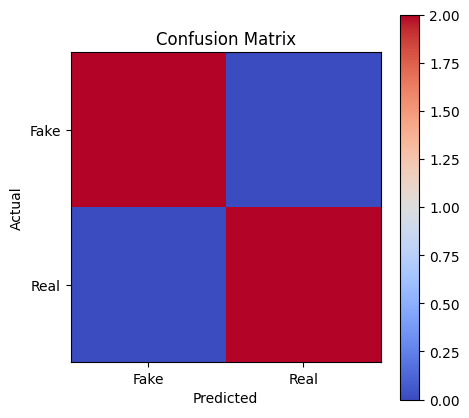

In [107]:
# --- EVALUATE MODEL ---
# (Place the evaluation code here)
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)  # Probabilities for confidence score

accuracy = accuracy_score(test_labels, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(classification_report(test_labels, y_pred))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="coolwarm", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Fake", "Real"])
plt.yticks([0,1], ["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Test Accuracy: 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



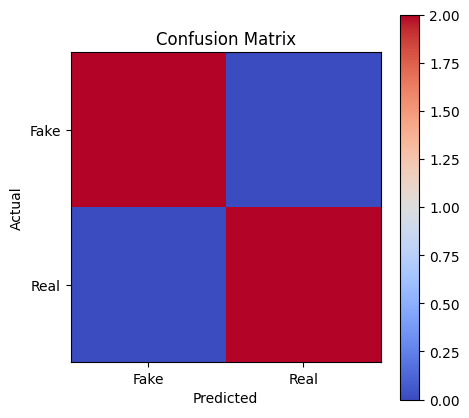

In [108]:
# --- EVALUATE MODEL ---
y_pred = best_svm.predict(X_test_scaled)
y_prob = best_svm.predict_proba(X_test_scaled)  # Probabilities for confidence score

accuracy = accuracy_score(test_labels, y_pred)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print(classification_report(test_labels, y_pred))

# --- CONFUSION MATRIX ---
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="coolwarm", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Fake", "Real"])
plt.yticks([0,1], ["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


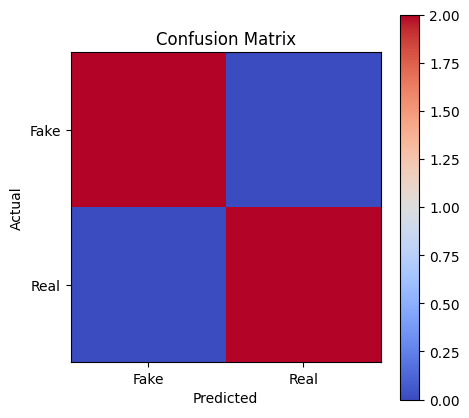

In [109]:
# --- CONFUSION MATRIX ---
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="coolwarm", interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["Fake", "Real"])
plt.yticks([0,1], ["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

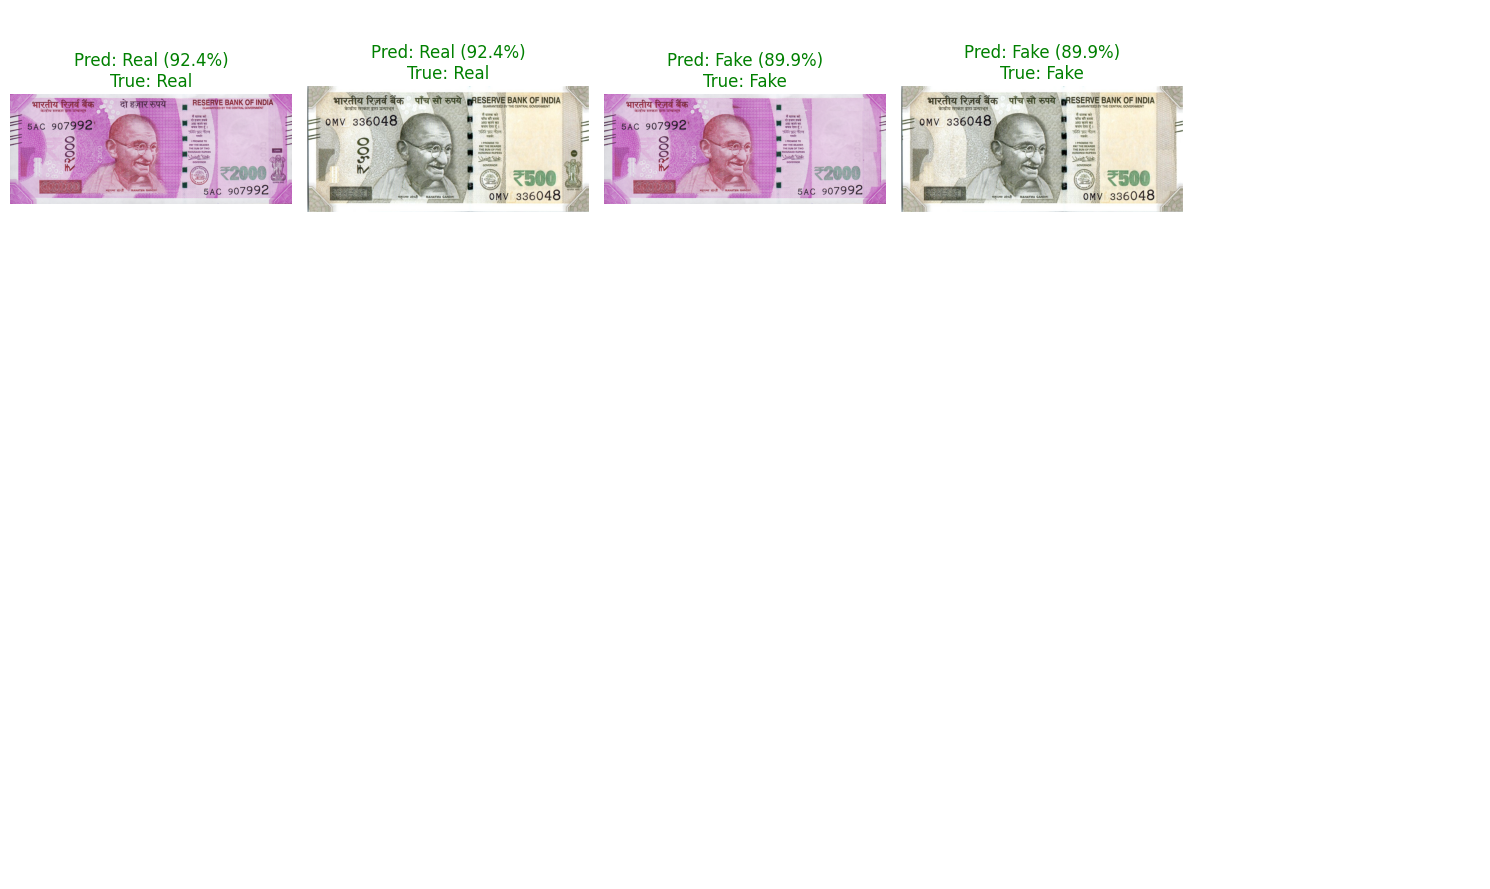

In [110]:
def visualize_predictions(images, labels, predictions, probabilities, file_paths):
    num_images = min(len(file_paths), 15)  # Limit to available images
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.ravel()

    for i in range(num_images):  # Iterate only up to available images
        img = cv2.imread(file_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        true_label = "Real" if labels[i] == 1 else "Fake"
        pred_label = "Real" if predictions[i] == 1 else "Fake"
        confidence = probabilities[i][predictions[i]] * 100

        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {pred_label} ({confidence:.1f}%)\nTrue: {true_label}",
                          color="green" if true_label == pred_label else "red")
        axes[i].axis("off")

    for j in range(num_images, 15):  # Hide any extra unused subplots
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Call function safely
visualize_predictions(test_images, test_labels, y_pred, y_prob, test_file_paths)


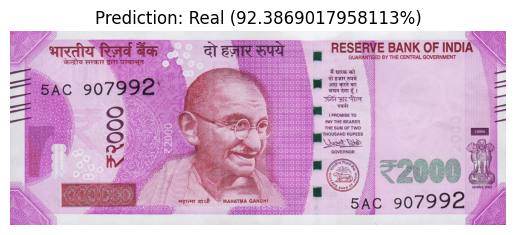

In [111]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def test_single_image(image_path):
    # Check if the image exists
    if not os.path.exists(image_path):
        print("Error: Image not found!")
        return

    # Read and resize image
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (128, 128))

    # Extract features
    feature = extract_features([img_resized])
    feature = scaler.transform(feature.reshape(1, -1))  # Ensure correct shape

    # Make prediction
    prediction = best_svm.predict(feature)[0]

    # Check if the model supports predict_proba
    if hasattr(best_svm, "predict_proba"):
        confidence = best_svm.predict_proba(feature)[0][prediction] * 100
    else:
        confidence = "N/A (SVM may not support predict_proba)"

    # Assign label
    label = "Real" if prediction == 1 else "Fake"

    # Display image with prediction
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {label} ({confidence}%)")
    plt.axis("off")
    plt.show()

# Example Usage
test_single_image('/content/drive/MyDrive/Dataset4/Testing/Real/Real1.jpg')


Accuracy: 100.00%


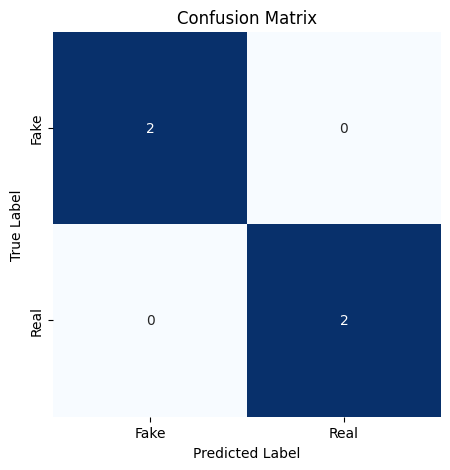


Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      1.00      1.00         2
        Real       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Assuming you have:
# - best_svm: Your trained SVM model
# - X_test_scaled: Your scaled test data
# - test_labels: The true labels for the test data

# 1. Predictions
y_pred = best_svm.predict(X_test_scaled)

# 2. Accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# 3. Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4. Classification Report (Precision, Recall, F1-score)
report = classification_report(test_labels, y_pred, target_names=["Fake", "Real"])
print("\nClassification Report:\n", report)

In [113]:
# Step 6: Evaluate Model
y_pred = best_svm.predict(X_test_scaled) # Use best_svm instead of svm_model and X_test_scaled instead of X_test
accuracy = accuracy_score(test_labels, y_pred) # Use test_labels instead of y_test
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(test_labels, y_pred)) # Use test_labels instead of y_test

Test Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

